In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
block_size: int = 3

In [4]:
words: list[str] = open("names.txt", 'r').read().splitlines()
print(words[:10])
print(len(words))


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033


In [5]:
chars: list[str] = sorted(list(set(''.join(words))))
stoi: dict[str, int] = {char: i + 1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos: dict[int, str] = {i: char for char, i in stoi.items()}
char_cnt: int = len(stoi)
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
def create_dataset(words: list[str], block_size: int) -> tuple[torch.Tensor, torch.Tensor]:
    X: list[list[int]] = []
    Y: list[int] = []
    for word in words:
        context: list[int] = [0] * block_size
        for ix in word + '.':
            X.append(context)
            Y.append(stoi[ix])
            context = context[1:] + [stoi[ix]]
    X_t = torch.tensor(X)
    Y_t = torch.tensor(Y)
    print(X_t.shape, Y_t.shape)
    return torch.tensor(X), torch.tensor(Y)

# Build the dataset
X_t, Y_t = create_dataset(words[:5], block_size)


torch.Size([32, 3]) torch.Size([32])


In [7]:
X_t.shape, X_t.dtype, Y_t.shape, Y_t.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [8]:
embed_dim: int = 2
num_neurons: int = 100


In [9]:
C = torch.randn((char_cnt, embed_dim))

In [10]:
print(C[5])
# Metric C can also be seen as a linear layer with no bias.
F.one_hot(torch.tensor([5]), num_classes=len(stoi)).float() @ C


tensor([-0.3731,  1.0734])


tensor([[-0.3731,  1.0734]])

In [11]:
emb = C[X_t]
print(emb.shape)

torch.Size([32, 3, 2])


In [12]:
W1 = torch.randn((block_size * embed_dim, num_neurons))
b1 = torch.randn(num_neurons)


In [13]:
emb[:, 0, :]

tensor([[-0.0197,  0.9045],
        [-0.0197,  0.9045],
        [-0.0197,  0.9045],
        [-0.3731,  1.0734],
        [ 2.8099, -0.8546],
        [-0.0197,  0.9045],
        [-0.0197,  0.9045],
        [-0.0197,  0.9045],
        [-0.0951, -0.8226],
        [-0.8343, -0.7855],
        [-0.2170,  0.4089],
        [-0.3615, -0.1081],
        [-0.0197,  0.9045],
        [-0.0197,  0.9045],
        [-0.0197,  0.9045],
        [ 0.9614,  0.5708],
        [-0.0197,  0.9045],
        [-0.0197,  0.9045],
        [-0.0197,  0.9045],
        [-0.2170,  0.4089],
        [-0.0577,  0.4368],
        [ 0.9614,  0.5708],
        [-0.7971, -0.8668],
        [-0.3731,  1.0734],
        [-0.8343, -0.7855],
        [-0.0197,  0.9045],
        [-0.0197,  0.9045],
        [-0.0197,  0.9045],
        [-0.0577,  0.4368],
        [-0.0951, -0.8226],
        [-0.4272, -0.1051],
        [-0.2775, -0.7129]])

In [14]:
print(torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape)
print(torch.cat(torch.unbind(emb, dim=1), dim=1).shape)
print(emb.view(-1, block_size * embed_dim).shape)

torch.Size([32, 6])
torch.Size([32, 6])
torch.Size([32, 6])


In [15]:
h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)


In [16]:
W2 = torch.randn((num_neurons, char_cnt))
b2 = torch.randn(char_cnt)

In [17]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [18]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [19]:
prob[0].sum()

tensor(1.)

In [20]:
prob[torch.arange(len(Y_t)), Y_t]

tensor([1.6539e-09, 4.2631e-09, 5.0255e-04, 2.9403e-03, 2.1648e-01, 7.2899e-01,
        5.9902e-07, 6.8047e-04, 6.3177e-11, 3.5664e-13, 7.7259e-06, 8.6998e-08,
        2.9601e-08, 1.5899e-04, 5.6292e-08, 1.3195e-10, 6.1532e-09, 1.1839e-12,
        1.2175e-07, 2.7316e-08, 4.2861e-20, 4.4494e-06, 3.5099e-08, 3.5740e-06,
        5.4667e-15, 6.0526e-13, 4.6269e-01, 6.7662e-05, 5.5466e-07, 3.7638e-08,
        2.2293e-03, 5.1880e-08])

In [21]:
loss = -prob[torch.arange(len(Y_t)), Y_t].log().mean()
loss

tensor(16.0669)

In [22]:
# Now group all the above code here.


In [23]:
X_t.shape, Y_t.shape


(torch.Size([32, 3]), torch.Size([32]))

In [24]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)
parameters = [C, W1, b1, W2, b2]


In [25]:
sum(p.nelement() for p in parameters)


3481

In [26]:
emb = C[X_t]
h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
loss = -prob[torch.arange(len(Y_t)), Y_t].log().mean()
loss

tensor(17.7697)

In [27]:
# Fused kernel is faster than the above code:
# 1. It avoids the creation of intermediate variables.
# 2. Forward pass is more efficient.
# 3. Backward pass is more efficient.
# 4. Numerical stability is improved. `1000` in `(-3, -2, -1, 0, 10000).exp()` will be `nan`.
F.cross_entropy(logits, Y_t)


tensor(17.7697)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
# Now use the full dataset.
X_t, Y_t = create_dataset(words, block_size)
g = torch.Generator().manual_seed(2147483647)

torch.Size([228146, 3]) torch.Size([228146])


In [30]:
C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

X_t = X_t.to(device)
Y_t = Y_t.to(device)
C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

epochs = 1000
lr = 0.1
loss = torch.tensor(1000.0)
for epoch in range(epochs):
    # Forward pass
    emb = C[X_t]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t)
    if (epoch % 10) == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

# This is slow.
print(f"Final loss: {loss.item()}")

Epoch: 0, Loss: 19.505231857299805
Epoch: 10, Loss: 10.709590911865234
Epoch: 20, Loss: 8.329218864440918
Epoch: 30, Loss: 6.794988632202148
Epoch: 40, Loss: 5.803151607513428
Epoch: 50, Loss: 5.105473518371582
Epoch: 60, Loss: 4.587387561798096
Epoch: 70, Loss: 4.202611446380615
Epoch: 80, Loss: 3.928121328353882
Epoch: 90, Loss: 3.728707790374756
Epoch: 100, Loss: 3.575533628463745
Epoch: 110, Loss: 3.454464912414551
Epoch: 120, Loss: 3.3569204807281494
Epoch: 130, Loss: 3.2768971920013428
Epoch: 140, Loss: 3.2100894451141357
Epoch: 150, Loss: 3.153406858444214
Epoch: 160, Loss: 3.1044838428497314
Epoch: 170, Loss: 3.0616233348846436
Epoch: 180, Loss: 3.023682117462158
Epoch: 190, Loss: 2.9899871349334717
Epoch: 200, Loss: 2.9601333141326904
Epoch: 210, Loss: 2.9337902069091797
Epoch: 220, Loss: 2.9105937480926514
Epoch: 230, Loss: 2.8900628089904785
Epoch: 240, Loss: 2.8717215061187744
Epoch: 250, Loss: 2.855135440826416
Epoch: 260, Loss: 2.8400444984436035
Epoch: 270, Loss: 2.82624

In [31]:
mini_batch_size: int = 32
torch.randint(0, X_t.shape[0], (mini_batch_size,))


tensor([ 86105, 166083, 161423, 181519,  79734, 125974,  24852, 190917,  17487,
        123029,   9275,   4341,  24524, 227321, 107210,   2809, 200121, 152002,
        199938, 143198, 209088,  56182, 129464, 161646, 184831,  76347,   6356,
        112879, 129262,   4831, 189259,   9149])

In [32]:
def calculate_loss(X_t: torch.Tensor, Y_t: torch.Tensor) -> torch.Tensor:
    emb = C[X_t]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, Y_t)


In [33]:
# Use mini-batch to speed up the training.

C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

X_t = X_t.to(device)
Y_t = Y_t.to(device)
C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

epochs = 5000
lr = 0.1
loss = torch.tensor(1000.0)
mini_batch_size: int = 64

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_t.shape[0], (mini_batch_size,))
    X_t_mini = X_t[ix]
    Y_t_mini = Y_t[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 100) == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

print(f"Final loss: {calculate_loss(X_t, Y_t).item()}")

Epoch: 0, Loss: 12.65859603881836
Epoch: 100, Loss: 3.4363341331481934
Epoch: 200, Loss: 2.414454221725464
Epoch: 300, Loss: 2.838775396347046
Epoch: 400, Loss: 2.9315476417541504
Epoch: 500, Loss: 2.6917057037353516
Epoch: 600, Loss: 2.6065428256988525
Epoch: 700, Loss: 2.4909915924072266
Epoch: 800, Loss: 2.5470430850982666
Epoch: 900, Loss: 2.5220787525177
Epoch: 1000, Loss: 2.8690507411956787
Epoch: 1100, Loss: 2.5303430557250977
Epoch: 1200, Loss: 2.7121737003326416
Epoch: 1300, Loss: 2.5296316146850586
Epoch: 1400, Loss: 2.614962100982666
Epoch: 1500, Loss: 2.5766372680664062
Epoch: 1600, Loss: 2.6925549507141113
Epoch: 1700, Loss: 2.5087413787841797
Epoch: 1800, Loss: 2.674154758453369
Epoch: 1900, Loss: 2.5972089767456055
Epoch: 2000, Loss: 2.343780040740967
Epoch: 2100, Loss: 2.4264063835144043
Epoch: 2200, Loss: 2.4597651958465576
Epoch: 2300, Loss: 2.47422456741333
Epoch: 2400, Loss: 2.4370830059051514
Epoch: 2500, Loss: 2.6660053730010986
Epoch: 2600, Loss: 2.67991805076599

In [34]:
# Find a good learning rate.
# Run the training for a few epochs find upper and lower bounds for the learning rate.

C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

X_t = X_t.to(device)
Y_t = Y_t.to(device)
C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

epochs = 1000
lr = 0.0001
loss = torch.tensor(1000.0)
mini_batch_size: int = 64

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_t.shape[0], (mini_batch_size,))
    X_t_mini = X_t[ix]
    Y_t_mini = Y_t[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

print(f"Final loss: {calculate_loss(X_t, Y_t).item()}")

Epoch: 0, Loss: 17.346752166748047
Epoch: 1, Loss: 17.13606071472168
Epoch: 2, Loss: 16.06056785583496
Epoch: 3, Loss: 15.21524429321289
Epoch: 4, Loss: 14.771906852722168
Epoch: 5, Loss: 16.066547393798828
Epoch: 6, Loss: 18.17630386352539
Epoch: 7, Loss: 17.74134063720703
Epoch: 8, Loss: 15.446073532104492
Epoch: 9, Loss: 16.756669998168945
Epoch: 10, Loss: 17.077146530151367
Epoch: 11, Loss: 15.771903038024902
Epoch: 12, Loss: 15.922130584716797
Epoch: 13, Loss: 16.909404754638672
Epoch: 14, Loss: 16.95201301574707
Epoch: 15, Loss: 15.9878511428833
Epoch: 16, Loss: 14.3302583694458
Epoch: 17, Loss: 15.617472648620605
Epoch: 18, Loss: 16.378719329833984
Epoch: 19, Loss: 16.116945266723633
Epoch: 20, Loss: 18.145841598510742
Epoch: 21, Loss: 16.14771270751953
Epoch: 22, Loss: 14.25469970703125
Epoch: 23, Loss: 14.163832664489746
Epoch: 24, Loss: 16.347566604614258
Epoch: 25, Loss: 14.53223991394043
Epoch: 26, Loss: 16.042308807373047
Epoch: 27, Loss: 14.565678596496582
Epoch: 28, Loss

Epoch: 0, Loss: 20.874019622802734
Epoch: 1, Loss: 19.60565185546875
Epoch: 2, Loss: 16.959653854370117
Epoch: 3, Loss: 18.660228729248047
Epoch: 4, Loss: 20.279094696044922
Epoch: 5, Loss: 20.57918930053711
Epoch: 6, Loss: 21.7209529876709
Epoch: 7, Loss: 20.768251419067383
Epoch: 8, Loss: 18.280139923095703
Epoch: 9, Loss: 17.178834915161133
Epoch: 10, Loss: 16.444780349731445
Epoch: 11, Loss: 16.49867057800293
Epoch: 12, Loss: 15.398845672607422
Epoch: 13, Loss: 16.1566104888916
Epoch: 14, Loss: 18.117422103881836
Epoch: 15, Loss: 13.852974891662598
Epoch: 16, Loss: 13.565032958984375
Epoch: 17, Loss: 14.932948112487793
Epoch: 18, Loss: 14.663244247436523
Epoch: 19, Loss: 12.668880462646484
Epoch: 20, Loss: 11.707319259643555
Epoch: 21, Loss: 14.185534477233887
Epoch: 22, Loss: 10.151468276977539
Epoch: 23, Loss: 12.83907699584961
Epoch: 24, Loss: 10.731866836547852
Epoch: 25, Loss: 11.243803977966309
Epoch: 26, Loss: 9.862714767456055
Epoch: 27, Loss: 10.710265159606934
Epoch: 28, 

Text(0, 0.5, 'Loss')

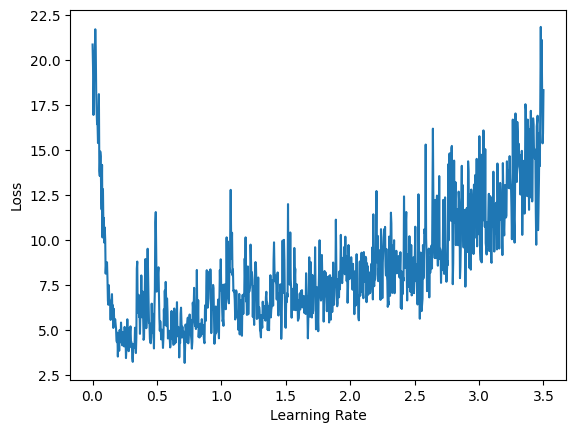

In [35]:
epochs = 1000
lrs = torch.linspace(0.0001, 3.5, epochs)

C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

X_t = X_t.to(device)
Y_t = Y_t.to(device)
C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

loss = torch.tensor(1000.0)
mini_batch_size: int = 64

lr_tracker = []
loss_tracker = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_t.shape[0], (mini_batch_size,))
    X_t_mini = X_t[ix]
    Y_t_mini = Y_t[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = lrs[epoch]
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    # Track the learning rate and loss
    lr_tracker.append(lr.item())
    loss_tracker.append(loss.item())

plt.plot(lr_tracker, loss_tracker)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")


In [36]:
C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

X_t = X_t.to(device)
Y_t = Y_t.to(device)
C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

epochs = 60000
loss = torch.tensor(1000.0)
mini_batch_size: int = 64

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_t.shape[0], (mini_batch_size,))
    X_t_mini = X_t[ix]
    Y_t_mini = Y_t[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 30000 else  0.01 if epoch < 45000 else 0.001

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

print(f"Final loss: {calculate_loss(X_t, Y_t).item()}")

Epoch: 0, Loss: 16.690288543701172
Epoch: 1000, Loss: 2.6528568267822266
Epoch: 2000, Loss: 2.1130781173706055
Epoch: 3000, Loss: 2.541175603866577
Epoch: 4000, Loss: 2.506476402282715
Epoch: 5000, Loss: 2.709012985229492
Epoch: 6000, Loss: 2.8301095962524414
Epoch: 7000, Loss: 2.5762996673583984
Epoch: 8000, Loss: 2.304352283477783
Epoch: 9000, Loss: 2.4186272621154785
Epoch: 10000, Loss: 2.443233013153076
Epoch: 11000, Loss: 2.4306368827819824
Epoch: 12000, Loss: 2.523226261138916
Epoch: 13000, Loss: 2.530113458633423
Epoch: 14000, Loss: 2.850740671157837
Epoch: 15000, Loss: 2.5796995162963867
Epoch: 16000, Loss: 2.5682079792022705
Epoch: 17000, Loss: 2.2963860034942627
Epoch: 18000, Loss: 2.4919636249542236
Epoch: 19000, Loss: 2.3854496479034424
Epoch: 20000, Loss: 2.4627151489257812
Epoch: 21000, Loss: 2.1912734508514404
Epoch: 22000, Loss: 2.2555015087127686
Epoch: 23000, Loss: 2.2682766914367676
Epoch: 24000, Loss: 2.354567050933838
Epoch: 25000, Loss: 2.596076011657715
Epoch: 26

In [37]:
# Generate train set, validation set and test set to solve the overfitting problem.

import random
random.seed(42)
random.shuffle(words)

train_set_ratio: float = 0.8
valid_set_ratio: float = 0.1
test_set_ratio: float = 0.1

n1: int = int(len(words) * train_set_ratio)
n2: int = int(len(words) * (train_set_ratio + valid_set_ratio))

X_train, Y_train = create_dataset(words[:n1], block_size)
X_val, Y_val = create_dataset(words[n1:n2], block_size)
X_test, Y_test = create_dataset(words[n2:], block_size)

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [38]:
# Increase the number of neurons to solve the underfitting problem.
num_neurons: int = 500
C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f"parameters: {sum(p.nelement() for p in parameters)}")

epochs = 70000
loss = torch.tensor(1000.0)
mini_batch_size: int = 64

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 30000 else  0.01 if epoch < 45000 else 0.001

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

parameters: 17081
Epoch: 0, Loss: 32.22364807128906
Epoch: 1000, Loss: 4.288580417633057
Epoch: 2000, Loss: 3.943786144256592
Epoch: 3000, Loss: 4.107909679412842
Epoch: 4000, Loss: 3.512852907180786
Epoch: 5000, Loss: 3.2255373001098633
Epoch: 6000, Loss: 2.7158761024475098
Epoch: 7000, Loss: 2.838256597518921
Epoch: 8000, Loss: 2.6503090858459473
Epoch: 9000, Loss: 2.7602593898773193
Epoch: 10000, Loss: 3.281614065170288
Epoch: 11000, Loss: 2.5666916370391846
Epoch: 12000, Loss: 2.5698189735412598
Epoch: 13000, Loss: 2.936060905456543
Epoch: 14000, Loss: 3.162635564804077
Epoch: 15000, Loss: 2.542574405670166
Epoch: 16000, Loss: 2.8444297313690186
Epoch: 17000, Loss: 2.733060359954834
Epoch: 18000, Loss: 2.7676122188568115
Epoch: 19000, Loss: 2.8505377769470215
Epoch: 20000, Loss: 2.7789294719696045
Epoch: 21000, Loss: 2.2049152851104736
Epoch: 22000, Loss: 2.487548589706421
Epoch: 23000, Loss: 2.820363759994507
Epoch: 24000, Loss: 2.6073756217956543
Epoch: 25000, Loss: 2.66959023475

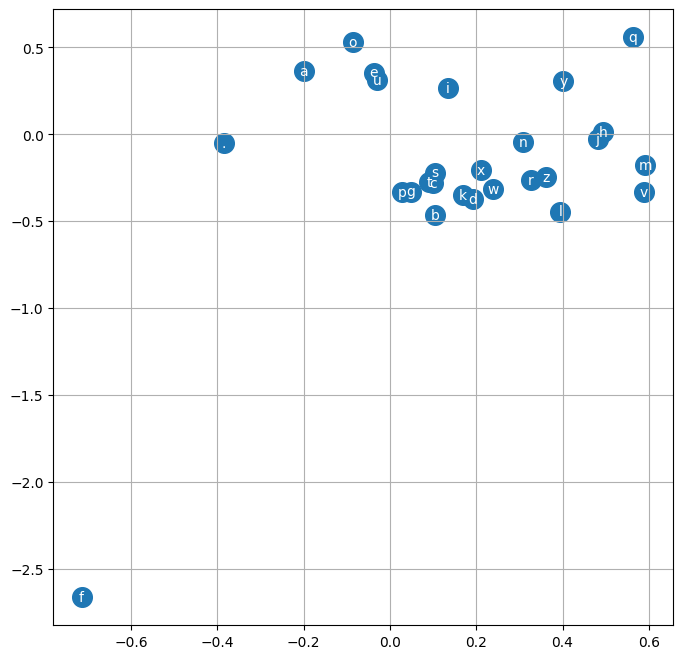

In [39]:
C = C.to('cpu')

plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid(True)


parameters: 36237
Epoch: 0, Loss: 29.703567504882812
Epoch: 1000, Loss: 5.769795894622803
Epoch: 2000, Loss: 5.405951976776123
Epoch: 3000, Loss: 4.1045379638671875
Epoch: 4000, Loss: 3.594989061355591
Epoch: 5000, Loss: 3.0308170318603516
Epoch: 6000, Loss: 2.810161828994751
Epoch: 7000, Loss: 2.8979899883270264
Epoch: 8000, Loss: 2.7112138271331787
Epoch: 9000, Loss: 2.5719339847564697
Epoch: 10000, Loss: 2.877917766571045
Epoch: 11000, Loss: 2.613447427749634
Epoch: 12000, Loss: 2.7346091270446777
Epoch: 13000, Loss: 2.4900782108306885
Epoch: 14000, Loss: 2.1089181900024414
Epoch: 15000, Loss: 2.6621768474578857
Epoch: 16000, Loss: 2.5726101398468018
Epoch: 17000, Loss: 2.177743673324585
Epoch: 18000, Loss: 2.9004013538360596
Epoch: 19000, Loss: 2.1355316638946533
Epoch: 20000, Loss: 2.2506778240203857
Epoch: 21000, Loss: 2.087388753890991
Epoch: 22000, Loss: 2.489254951477051
Epoch: 23000, Loss: 2.3462178707122803
Epoch: 24000, Loss: 2.387474775314331
Epoch: 25000, Loss: 2.47855401

Text(0, 0.5, 'Loss (log10)')

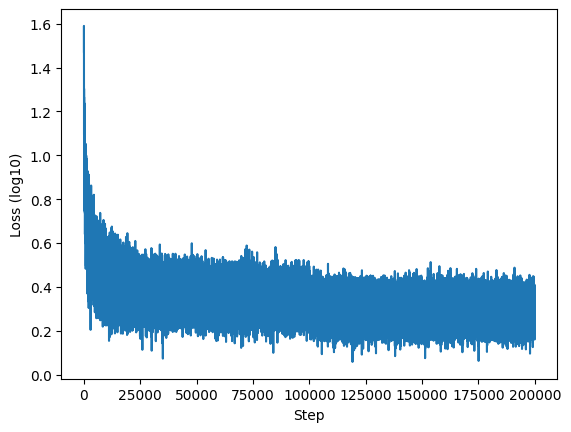

In [45]:
# Increase the number of the dimensions of the embedding to solve the underfitting problem.

num_neurons: int = 300
embed_dim: int = 30
C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f"parameters: {sum(p.nelement() for p in parameters)}")

epochs = 200000
loss = torch.tensor(1000.0)
mini_batch_size: int = 32

lossi = []
stepi = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 100000 else  0.01 if epoch < 150000 else 0.001

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss (log10)")


In [41]:
# Now sample from the trained model.

C = C.to('cpu')
W1 = W1.to('cpu')
b1 = b1.to('cpu')
W2 = W2.to('cpu')
b2 = b2.to('cpu')

g = torch.Generator().manual_seed(12123 + 10)
num_samples: int = 20

for _ in range(num_samples):
    out: list[str] = []
    context: list[int] = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix: int = int(
            torch.multinomial(probs, num_samples=1, generator=g).item()
        )
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))


aarvinclarlowanay.
yamaddil.
kaylyn.
manverlyn.
roae.
cammitrice.
darah.
suir.
edi.
oothya.
kennentelvi.
avery.
szee.
dionato.
emance.
miley.
amaan.
ayah.
nandelin.
larillikianna.


parameters: 36237
Epoch: 0, Loss: 37.047706604003906
Epoch: 1000, Loss: 6.92907190322876
Epoch: 2000, Loss: 4.358158111572266
Epoch: 3000, Loss: 5.832645893096924
Epoch: 4000, Loss: 4.091616630554199
Epoch: 5000, Loss: 2.8677873611450195
Epoch: 6000, Loss: 2.3255367279052734
Epoch: 7000, Loss: 3.583768606185913
Epoch: 8000, Loss: 1.9931182861328125
Epoch: 9000, Loss: 2.9161036014556885
Epoch: 10000, Loss: 2.946800947189331
Epoch: 11000, Loss: 3.3782575130462646
Epoch: 12000, Loss: 2.631404399871826
Epoch: 13000, Loss: 2.6534690856933594
Epoch: 14000, Loss: 2.083164930343628
Epoch: 15000, Loss: 3.275927782058716
Epoch: 16000, Loss: 2.2151596546173096
Epoch: 17000, Loss: 1.976353406906128
Epoch: 18000, Loss: 2.0574100017547607
Epoch: 19000, Loss: 2.5055277347564697
Epoch: 20000, Loss: 2.668558359146118
Epoch: 21000, Loss: 3.2818431854248047
Epoch: 22000, Loss: 2.891486883163452
Epoch: 23000, Loss: 2.0418241024017334
Epoch: 24000, Loss: 2.43863582611084
Epoch: 25000, Loss: 2.8618900775909

Text(0, 0.5, 'Loss (log10)')

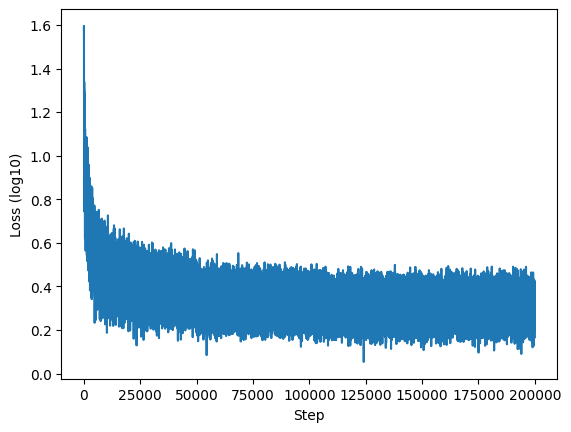

In [ ]:
# Add direct connection from the input to the output.

num_neurons: int = 300
embed_dim: int = 30
C = torch.randn((char_cnt, embed_dim), generator=g)
W0 = torch.randn((block_size * embed_dim, char_cnt), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

C = C.to(device)
W0 = W0.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W0, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f"parameters: {sum(p.nelement() for p in parameters)}")

epochs = 200000
loss = torch.tensor(1000.0)
mini_batch_size: int = 32

lossi = []
stepi = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = b2 + emb.view(-1, block_size * embed_dim) @ W0 + h @ W2
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = (0.1 if epoch < 50000 else
          0.05 if epoch < 100000 else
          0.01)

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())

def calculate_loss_direct(X_t: torch.Tensor, Y_t: torch.Tensor) -> torch.Tensor:
    emb = C[X_t]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    # emb.view(-1, block_size * embed_dim) @ W0: Direct connection from
    # the input to the output.
    logits = b2 + emb.view(-1, block_size * embed_dim) @ W0 + h @ W2
    return F.cross_entropy(logits, Y_t)

print(f"Train set loss: {calculate_loss_direct(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss_direct(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss_direct(X_test, Y_test).item()}")

plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss (log10)")


In [54]:
# Now sample from the trained model.

C = C.to('cpu')
W0 = W0.to('cpu')
W1 = W1.to('cpu')
b1 = b1.to('cpu')
W2 = W2.to('cpu')
b2 = b2.to('cpu')

g = torch.Generator().manual_seed(12123 + 10)
num_samples: int = 20

for _ in range(num_samples):
    out: list[str] = []
    context: list[int] = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = b2 + emb.view(-1, block_size * embed_dim) @ W0 + h @ W2
        probs = F.softmax(logits, dim=1)
        ix: int = int(
            torch.multinomial(probs, num_samples=1, generator=g).item()
        )
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

aatvi.
coltlan.
dan.
yajanci.
reigh.
cal.
nykai.
muraa.
anshmiarendelanah.
justyes.
koltlyn.
fernson.
lyn.
every.
dianne.
jaytone.
korbeniold.
amaad.
yecten.
natlan.
